In [4]:
import spacy #for tokenization and lemmatization
nlp = spacy.load('en_core_web_sm')
lemmatizer = nlp.get_pipe("lemmatizer")

import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn #to use WordNet

import re #regular expression for removing punctuations
import requests #read the British to American dictionary
import pandas as pd
import csv

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shaderein/nltk_data...


In [14]:
excluded_response = ["can't","cannot","can not","can't see","cant see",'barely see','cannot see','no see',"not see", "dont see", "hardly see", 'cammot see',"didnt see","dont really see","seems nobody","cnt see"]

In [5]:
url ="https://raw.githubusercontent.com/hyperreality/American-British-English-Translator/master/data/british_spellings.json"
british_to_american = requests.get(url).json()

In [6]:
root = "."
file = "exp_vehicle_bdd.csv"
import os

exp = pd.read_csv(os.path.join(root, file)) #Read the file with explanation text
# Label: vehicle, human
# Category: person, rider, car, bus, truck
exp = exp.astype({'text':'string','image':'string','label':'string','category':'string'})
exp.head()

,Unnamed: 0,subject_no,Trial_Index_,block,text,block_sequence,block_name,block_num,path,image,trialID,label,category,number,lastBlockType
0,0,1,1,2,he is walking with legs,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,411.jpg,1,human,person,NaN,NaN
1,1,1,2,2,slim with legs and hand,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,608.jpg,2,human,person,NaN,NaN
2,2,1,3,2,human face,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,480.jpg,3,human,person,NaN,NaN
3,3,1,4,2,human cloth with hat,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,85.jpg,4,human,person,NaN,NaN
4,4,1,5,2,human back with t shirt,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,703.jpg,5,human,person,NaN,NaN


In [7]:
def preprocess(row):
    #TODO: how to handle trials skipped with empty explanation? shouldn't count it in when calculating score mean for this subject (Fine if we get 0 scores which has no effect when taking average?)
    if pd.isna(row['text']): return []

    # Clean trials where subject answer they didn't see the image
    for keywords in excluded_response:
        if keywords in row['text'].lower():
            return []  

    string = re.sub(r'[^\w\s]', '', row['text']) #Remove punctuations
    sentence = nlp(string) #Apply Spacy
    lemma_list = [token.lemma_ for token in sentence] #Lemmatization
    am_list = [] #Empty list to put changed spellings
    for word in lemma_list:
        if word in british_to_american:
            am_list.append(british_to_american[word]) #Replace with American spelling if there is a difference
        else:
            am_list.append(word) #Just append the original word if there is no difference
    return am_list

exp['tokenized'] = exp.apply(lambda row: preprocess(row), axis = 1) #Process explanations
exp.head()

,Unnamed: 0,subject_no,Trial_Index_,block,text,block_sequence,block_name,block_num,path,image,trialID,label,category,number,lastBlockType,tokenized
0,0,1,1,2,he is walking with legs,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,411.jpg,1,human,person,NaN,NaN,"[he, be, walk, with, leg]"
1,1,1,2,2,slim with legs and hand,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,608.jpg,2,human,person,NaN,NaN,"[slim, with, leg, and, hand]"
2,2,1,3,2,human face,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,480.jpg,3,human,person,NaN,NaN,"[human, face]"
3,3,1,4,2,human cloth with hat,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,85.jpg,4,human,person,NaN,NaN,"[human, cloth, with, hat]"
4,4,1,5,2,human back with t shirt,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,703.jpg,5,human,person,NaN,NaN,"[human, back, with, t, shirt]"


In [8]:
def get_rating(item):
    rating = {}
    with open('./sensorimotor.csv') as file: #Read the file with sensorimotor strength ratings
        reader = csv.DictReader(file)
        for row in reader:
            rating[row['word']] = float(row[item]) #Convert ratings into dictionaries
    return rating

visual_dict = get_rating('visual')

In [9]:
def avg_rating(row, dict_name): #Calculate average rating per word for each explanation
    rating_list = []
    for lemma in row['tokenized']:
        lemma = lemma.upper()
        if lemma in dict_name:
            rating_list.append(dict_name[lemma])
    if len(rating_list) != 0:
        return sum(rating_list)/len(rating_list)
    else:
        return 0

In [ ]:
max(visual_dict.values())

5.0

In [10]:
exp['visual'] = exp.apply(lambda row: avg_rating(row, visual_dict), axis = 1) #Get visual strength for each explanation

exp.head()

,Unnamed: 0,subject_no,Trial_Index_,block,text,block_sequence,block_name,block_num,path,image,trialID,label,category,number,lastBlockType,tokenized,visual
0,0,1,1,2,he is walking with legs,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,411.jpg,1,human,person,NaN,NaN,"[he, be, walk, with, leg]",3.197386
1,1,1,2,2,slim with legs and hand,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,608.jpg,2,human,person,NaN,NaN,"[slim, with, leg, and, hand]",3.422308
2,2,1,3,2,human face,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,480.jpg,3,human,person,NaN,NaN,"[human, face]",4.836111
3,3,1,4,2,human cloth with hat,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,85.jpg,4,human,person,NaN,NaN,"[human, cloth, with, hat]",4.298203
4,4,1,5,2,human back with t shirt,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,703.jpg,5,human,person,NaN,NaN,"[human, back, with, t, shirt]",3.950868


In [36]:
wn_lemmas = set(wn.all_lemma_names()) #Get all lemmas in WordNet

def avg_similarity(row, col): #Calculate average similarity to the label for each explanation
    sim_list = []
    label = row[col]
    # if label == 'Tennis Ball': #Dealing with the special case of the two-word label, tennis ball
    #     label = 'tennis_ball'
    for lemma in row['tokenized']:
        if lemma in wn_lemmas: #Check if the word is in WordNet
            sim = wn.synsets(label)[0].path_similarity(wn.synsets(lemma)[0],simulate_root = False) #Disable simulate root so that we only get similarities for nouns
            if sim is not None: #For other parts of speech, similarity will be empty
                sim_list.append(sim)
    if len(sim_list) != 0:
        return sum(sim_list)/len(sim_list)
    else:
        return 0
    
def valid_wordnet_vocab(row, col): #Calculate average similarity to the label for each explanation
    vocab_list = []
    label = row[col]
    # if label == 'Tennis Ball': #Dealing with the special case of the two-word label, tennis ball
    #     label = 'tennis_ball'
    for lemma in row['tokenized']:
        if lemma in wn_lemmas: #Check if the word is in WordNet
            sim = wn.synsets(label)[0].path_similarity(wn.synsets(lemma)[0],simulate_root = False) #Disable simulate root so that we only get similarities for nouns
            if sim is not None: #For other parts of speech, similarity will be empty
                vocab_list.append(lemma)
    return vocab_list
    
exp['wordnet_similarity_label'] = exp.apply(lambda row: avg_similarity(row, 'label'), axis = 1) #Get WordNet similarity for each explanation
exp['wordnet_similarity_category'] = exp.apply(lambda row: avg_similarity(row, 'category'), axis = 1) #Get WordNet similarity for each explanation
exp['wordnet_vocab'] = exp.apply(lambda row: valid_wordnet_vocab(row, 'category'), axis = 1) #Get WordNet similarity for each explanation
exp[:10]

,Unnamed: 0,subject_no,Trial_Index_,block,text,block_sequence,block_name,block_num,path,image,trialID,label,category,number,lastBlockType,tokenized,visual,wordnet_similarity_label,wordnet_similarity_category,wordnet_vocab
0,0,1,1,2,he is walking with legs,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,411.jpg,1,human,person,NaN,NaN,"[he, be, walk, with, leg]",3.197386,0.051964,0.111195,"[he, be, walk, leg]"
1,1,1,2,2,slim with legs and hand,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,608.jpg,2,human,person,NaN,NaN,"[slim, with, leg, and, hand]",3.422308,0.051316,0.105556,"[leg, hand]"
2,2,1,3,2,human face,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,480.jpg,3,human,person,NaN,NaN,"[human, face]",4.836111,0.527778,0.112500,"[human, face]"
3,3,1,4,2,human cloth with hat,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,85.jpg,4,human,person,NaN,NaN,"[human, cloth, with, hat]",4.298203,0.379808,0.125926,"[human, cloth, hat]"
4,4,1,5,2,human back with t shirt,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,703.jpg,5,human,person,NaN,NaN,"[human, back, with, t, shirt]",3.950868,0.292236,0.111219,"[human, back, t, shirt]"
5,5,1,6,2,human legs and head,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,760.jpg,6,human,person,NaN,NaN,"[human, leg, and, head]",3.583806,0.368519,0.108333,"[human, leg, head]"
6,6,1,7,2,human shape.small human head,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,452.jpg,7,human,person,NaN,NaN,"[human, shapesmall, human, head]",4.639376,0.685185,0.108333,"[human, human, head]"
7,7,1,8,2,"head arms, hands and legs",2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,865.jpg,8,human,person,NaN,NaN,"[head, arm, hand, and, leg]",3.536237,0.052047,0.109028,"[head, arm, hand, leg]"
8,8,1,9,2,red clothesand arm on the back,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,845.jpg,9,human,person,NaN,NaN,"[red, clothesand, arm, on, the, back]",3.102239,0.052148,0.111255,"[red, arm, back]"
9,9,1,10,2,standing human with arms and legs,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,422.jpg,10,human,person,NaN,NaN,"[stand, human, with, arm, and, leg]",3.529954,0.290625,0.102778,"[stand, human, arm, leg]"


,Unnamed: 0,subject_no,Trial_Index_,block,text,block_sequence,block_name,block_num,path,image,trialID,label,category,number,lastBlockType,tokenized,visual,wordnet_similarity_label,wordnet_similarity_category,wordnet_vocab
0,0,1,1,2,he is walking with legs,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,411.jpg,1,human,person,NaN,NaN,"[he, be, walk, with, leg]",3.197386,0.051964,0.111195,[he]
1,1,1,2,2,slim with legs and hand,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,608.jpg,2,human,person,NaN,NaN,"[slim, with, leg, and, hand]",3.422308,0.051316,0.105556,[]
2,2,1,3,2,human face,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,480.jpg,3,human,person,NaN,NaN,"[human, face]",4.836111,0.527778,0.112500,[human]
3,3,1,4,2,human cloth with hat,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,85.jpg,4,human,person,NaN,NaN,"[human, cloth, with, hat]",4.298203,0.379808,0.125926,[human]
4,4,1,5,2,human back with t shirt,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,703.jpg,5,human,person,NaN,NaN,"[human, back, with, t, shirt]",3.950868,0.292236,0.111219,[human]
5,5,1,6,2,human legs and head,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,760.jpg,6,human,person,NaN,NaN,"[human, leg, and, head]",3.583806,0.368519,0.108333,[human]
6,6,1,7,2,human shape.small human head,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,452.jpg,7,human,person,NaN,NaN,"[human, shapesmall, human, head]",4.639376,0.685185,0.108333,[human]
7,7,1,8,2,"head arms, hands and legs",2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,865.jpg,8,human,person,NaN,NaN,"[head, arm, hand, and, leg]",3.536237,0.052047,0.109028,[head]
8,8,1,9,2,red clothesand arm on the back,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,845.jpg,9,human,person,NaN,NaN,"[red, clothesand, arm, on, the, back]",3.102239,0.052148,0.111255,[red]
9,9,1,10,2,standing human with arms and legs,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,422.jpg,10,human,person,NaN,NaN,"[stand, human, with, arm, and, leg]",3.529954,0.290625,0.102778,[stand]


Should the explanation with original word be excluded?

WordCloud

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
from PIL import Image, ImageColor
import numpy as np

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shaderein/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/shaderein/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

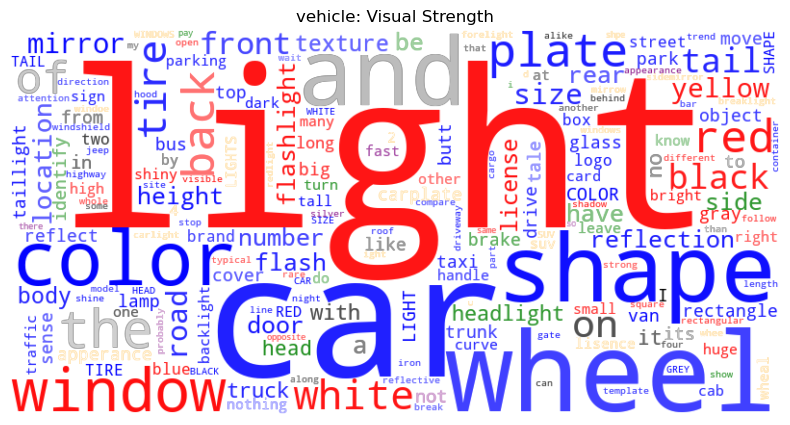

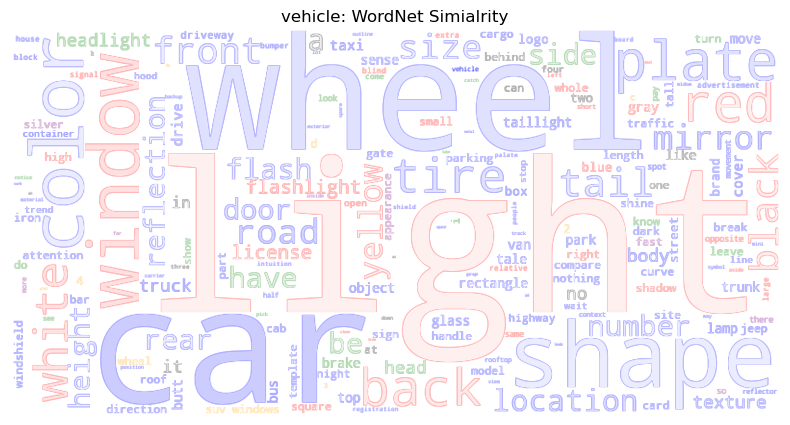

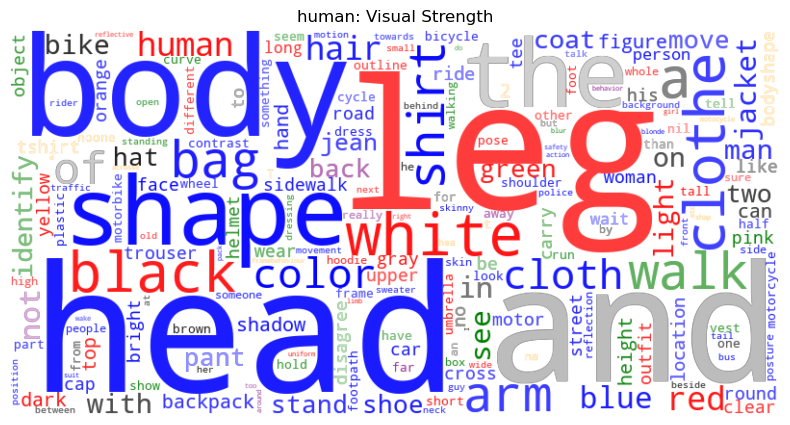

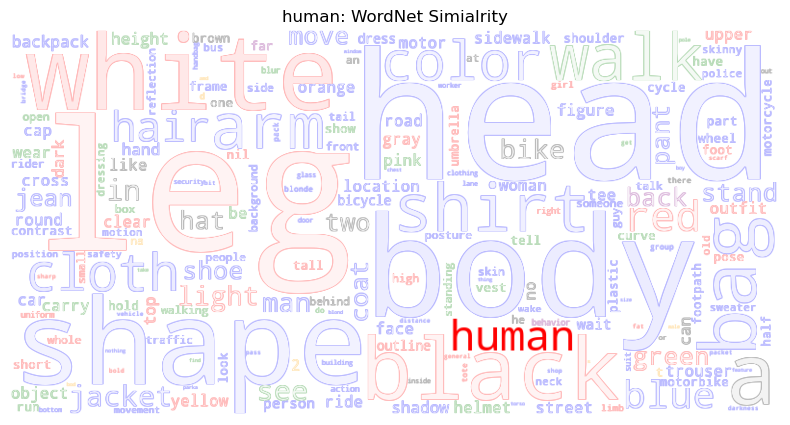

In [39]:
# # Function to preprocess text
# def preprocess_text(text):
#     for term in excluded_response:
#         if term in text: return []
#     stop_words = set(stopwords.words('english'))
#     words = nltk.word_tokenize(text.lower())
#     words = [word for word in words if word.isalpha() and word not in stop_words]
#     return words

# Function to determine the color of the word based on POS
def get_color(word, pos):
    color_dict = {
        'NN': 'blue',    # Noun
        'VB': 'green',   # Verb
        'JJ': 'red',     # Adjective
        'RB': 'purple',  # Adverb
    }
    return color_dict.get(pos[:2], 'black')

# Function to create the word cloud
def create_word_cloud(word_freq, tagged_words, word_values,title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', mode='RGBA', collocations=False)
    
    def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        if word.lower() in word_values:
            pos = [tag for (w, tag) in tagged_words if w == word][0]
            color = get_color(word, pos)
            rgb = ImageColor.getrgb(color)
            alpha = int(word_values.get(word, 1.0) * 255)
            return (rgb[0], rgb[1], rgb[2], alpha)
        else: # words not included when calculating the score
            color = "orange"
            rgb = ImageColor.getrgb(color)
            alpha = 1
            return (rgb[0], rgb[1], rgb[2], alpha)

    wordcloud.generate_from_frequencies(word_freq)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud.recolor(color_func=color_func, random_state=3), interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()


# Create a list of all words in the dataframe
for category in ['vehicle','human']:
        
    all_words = []
    for tokenized in exp[exp['label']==category]['tokenized']:
        all_words.extend(tokenized)

    # Tag words with their POS
    tagged_words = pos_tag(all_words)

    # Create a dictionary of word frequencies
    word_freq = nltk.FreqDist(all_words)

    # Visual strength
    visual_strength = {}
    for lemma in word_freq:
        lemma = lemma.upper()
        if lemma in visual_dict:
            visual_strength[lemma.lower()] = visual_dict[lemma] / 5 # visual strength [0,5]

    # Generate and display the word cloud
    create_word_cloud(word_freq, tagged_words, visual_strength,title=f"{category}: Visual Strength")

    # Conceptual information
    all_words = []
    for tokenized in exp[exp['label']==category]['wordnet_vocab']:
        all_words.extend(tokenized)

    # Create a dictionary of word frequencies
    word_freq = nltk.FreqDist(all_words)

    # Visual strength
    visual_strength = {}
    for lemma in word_freq:
        lemma = lemma.upper()
        if lemma in visual_dict:
            visual_strength[lemma.lower()] = wn.synsets(category)[0].path_similarity(wn.synsets(lemma)[0],simulate_root = False)

    # Generate and display the word cloud
    create_word_cloud(word_freq, tagged_words, visual_strength,title=f"{category}: WordNet Simialrity")